In [90]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from albumentations.pytorch import ToTensorV2

import albumentations as A
import monai

from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import time
from collections import defaultdict
import copy
import gc

from utils.dataset import EchoDataset_heatmap
from utils.train import *
from utils.evaluation import *
from utils.optimizer import *
from utils.utils import *

import wandb
import warnings

warnings.filterwarnings("ignore")


In [92]:
### Logging part
import logging
from datetime import datetime
from pytz import timezone
import sys

import random

def log(CFG):
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    def timetz(*args):
        return datetime.now(tz).timetuple()
    tz = timezone('Asia/Seoul')
    logging.Formatter.converter = timetz

    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    # log 출력
    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(formatter)
    logger.addHandler(stream_handler)

    # log를 파일에 출력
    file_handler = logging.FileHandler(os.path.join('saved_model', CFG['version'], f"{CFG['view']}-{CFG['dataset']}-{CFG['backbone']}.log"))
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    logger.info(f"python {' '.join(sys.argv)}")
    logger.info("Timezone: " + str(tz))
    logger.info(f"Training Start")
    return logger


In [93]:
def seed_everything(seed: int=0):    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything()

## ⚙️ Configuration

In [94]:
view2cls_dict = {
    'PLAX': 3,
    'PSAX': 0,
    '2CH': 2,
    '4CH': 2,
}
class cfg:
    def __getitem__(self,key):
        return getattr(self, key)
    def __setitem__(self,key,value):
        return setattr(self, key, value)

    height = 480   
    width = 640
    view = 'PLAX'
    dataset = 'EchoNetLVH'
    lr = 1e-3
    scheduler = 'LambdaLR'
    reducelr_factor = 0.99
    min_lr = 1e-5
    device = torch.device('mps')
    epochs = 200
    patience = 50
    batch_size = 2

    ############## Heatmap hyperparameter
    std = 7
    ##############
    backbone = 'resnet50'
    version = 'resnet50'
    
CFG = cfg()

os.makedirs(os.path.join('saved_model', CFG['version']), exist_ok=True)

In [95]:

logger = log(CFG)
trace_func = logger.info

2022-10-16 21:49:56,243 - python /opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.8/site-packages/ipykernel_launcher.py -f /Users/kyh/Library/Jupyter/runtime/kernel-46f3769b-4d00-4753-92a9-e86c898b866f.json


2022-10-16 21:49:56,243 - root - INFO - python /opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.8/site-packages/ipykernel_launcher.py -f /Users/kyh/Library/Jupyter/runtime/kernel-46f3769b-4d00-4753-92a9-e86c898b866f.json
2022-10-16 21:49:56,243 - root - INFO - python /opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.8/site-packages/ipykernel_launcher.py -f /Users/kyh/Library/Jupyter/runtime/kernel-46f3769b-4d00-4753-92a9-e86c898b866f.json


2022-10-16 21:49:56,245 - Timezone: Asia/Seoul


2022-10-16 21:49:56,245 - root - INFO - Timezone: Asia/Seoul
2022-10-16 21:49:56,245 - root - INFO - Timezone: Asia/Seoul


2022-10-16 21:49:56,247 - Training Start


2022-10-16 21:49:56,247 - root - INFO - Training Start
2022-10-16 21:49:56,247 - root - INFO - Training Start


In [96]:
dataset_dir = 'output'

## 📀 Load Data

In [97]:
from albumentations.core.transforms_interface import ImageOnlyTransform

class MinMaxNormalize(ImageOnlyTransform):
    """
    Min-max normalization
    """
    def apply(self, img, **param):
        # minmax normalize
        img = (img - img.min()) / (img.max() - img.min())
        return img


In [98]:
train_ts = A.Compose([
    A.Resize(CFG['height'], CFG['width']),
    A.HorizontalFlip(p=.5),
    A.VerticalFlip(p=.3),
    # A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2,
    #                 rotate_limit=10, p=0.2),
    A.SafeRotate(limit=30),

    A.OneOf([
        A.MedianBlur(blur_limit=3, p=0.1),
        A.MotionBlur(p=0.2),
    ], p=0.2),
    # A.OneOf([
    #     A.OpticalDistortion(p=0.3),
    # ], p=0.2),
    A.OneOf([
        A.GaussNoise(p=0.2),
        A.MultiplicativeNoise(p=0.2),
    ], p=0.2),
    A.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=0,
                         val_shift_limit=0.1, p=0.3),
    MinMaxNormalize(p=1),

    # ToTensorV2(),

],
    keypoint_params=A.KeypointParams(format='xy')
)
test_ts = A.Compose([
        A.Resize(CFG['height'], CFG['width']),
        MinMaxNormalize(p=1),
        # ToTensorV2(),
        ],
        keypoint_params=A.KeypointParams(format='xy')
        )


In [99]:
ds = EchoDataset_heatmap(root=dataset_dir, split='train', transforms=test_ts)
dl = DataLoader(ds, batch_size=1, shuffle=False, )
s = dl.__iter__().__next__()
s

{'data': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 'label': tensor([[[345.0000, 191.8750],
          [337.5000, 213.1250],
          [298.7500, 317.5000],
          [291.2500, 340.0000]]]),
 'id': ['0X74FA16DE8ADD4FE6'],
 'height': tensor([768]),
 'width': tensor([1024])}

In [100]:
train_ds = EchoDataset_heatmap(root=dataset_dir, split='train', transforms=train_ts)
valid_ds = EchoDataset_heatmap(root=dataset_dir, split='val', transforms=test_ts)

train_dl = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=CFG.batch_size//2, shuffle=False)

## 🧮 Load Model

In [101]:
# https://github.com/echonet/lvh/blob/master/models.py
import torch
import torchvision
from pathlib import Path

class PlaxModel(torch.nn.Module):

    """Model used for prediction of PLAX measurement points.
    Output channels correspond to heatmaps for the endpoints of
    measurements of interest.
    """

    def __init__(self, 
            measurements=['LVPW', 'LVID', 'IVS'], 
        ) -> None:
        super().__init__()
        self.model = torchvision.models.segmentation.deeplabv3_resnet50(num_classes=len(measurements) + 1)

    def forward(self, x):
        return torch.sigmoid(self.model(x)['out'])


In [102]:
from utils.train_heatmap import train_one_epoch, valid_one_epoch

In [103]:

def run_training(model, train_dl, val_dl, optimizer, scheduler, criterion, CFG, wandb):
    """
    모델, 데이터를 받아 학습/검증 수행후 결과에 대해 출력 및 모델 저장
    """
    device = CFG['device']
    num_epochs = CFG['epochs']
    start = time.time()
    early_stopping = EarlyStopping(patience=CFG['patience'], verbose=True, trace_func=trace_func)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_mde = np.inf
    # best_loss = 
    best_epoch = -1
    history = defaultdict(list)
    # 에폭만큼 학습 수행
    for epoch in range(1, num_epochs+1):
        gc.collect()
        # 에폭 단위 학습 수행
        train_loss, train_mde = train_one_epoch(model=model, dataloader=train_dl, optimizer=optimizer, scheduler=scheduler, device=device, criterion=criterion, CFG=CFG)
        # 에폭 단위 검증 수행
        val_loss, val_mde = valid_one_epoch(model=model, dataloader=val_dl, device=device, criterion=criterion, CFG=CFG)
        early_stopping(val_loss, model)

        history['Train Loss'].append(train_loss)
        history['Train MDE'].append(train_mde)
        history['Valid Loss'].append(val_loss)
        history['Valid MDE'].append(val_mde)
        
        wandb.log({"Train Loss": train_loss, 
            "Train MDE": train_mde,
            "Valid Loss": val_loss,
            "Valid MDE": val_mde,
            "LR":scheduler.get_last_lr()[0]})

        trace_func(f"[Epoch {epoch}/{CFG['epochs']}: Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}, Train MDE: {train_mde:.5f}, Val MDE: {val_mde:.5f}")
        
        if scheduler is not None:
            scheduler.step()
        # validation MDE가 개선이 된 경우 모델을 저장
        if val_mde <= best_mde:
            trace_func(f"Valid Score Improved ({best_mde:.4f} ---> {val_mde:.4f})")
            best_mde = val_mde
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            
            wandb.run.summary['Best MDE'] = best_mde
            wandb.run.summary['Best Epoch'] = best_epoch

            model_name = f"best_epoch-{CFG['view']}-{CFG['dataset']}-{CFG['backbone']}.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict':optimizer.state_dict(),
                'loss': val_loss,
                'metric': val_mde
                }, 
                os.path.join(f"saved_model", CFG['version'], model_name))

            trace_func(f"Model Saved")
        # Loss 최소일때
        # if best_loss 
        if early_stopping.early_stop:
            trace_func("Early stopping")
            break

    model_name = f"last_epoch-{CFG['view']}-{CFG['dataset']}-{CFG['backbone']}.pth"
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict':optimizer.state_dict(),
                'loss': val_loss
                }, 
                os.path.join(f"saved_model", CFG['version'], model_name))
    
    end = time.time()
    time_elapsed = end-start
    trace_func("Trianing complete in {:.0f}h {:.0f}m {:.0f}s".format(time_elapsed//3600, (time_elapsed%3600)//60, (time_elapsed%3600)%60))
    trace_func("Best Val MDE: {:.4f}".format(best_mde))

    model.load_state_dict(best_model_wts)

    return model, history

In [104]:
# https://github.com/qubvel/segmentation_models.pytorch
import segmentation_models_pytorch as smp
model = smp.Unet(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=4,                      # model output channels (number of classes in your dataset)
    activation='softmax'
    
)

In [105]:

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)       
        batch_size = inputs.size(0)
        num_joints = inputs.size(1)
        all_dice = 0
        for idx in range(num_joints):
        #flatten label and prediction tensors
            input = inputs[:,idx].reshape(-1)
            target = targets[:,idx].reshape(-1)
        
            intersection = (input * target).sum()                            
            dice = (2.*intersection + smooth)/(input.sum() + target.sum() + smooth)  
            all_dice += dice
        return 1 - all_dice/num_joints


In [106]:
from utils.loss import HeatmapMSELoss, HeatmapOHKMMSELoss, JointsRMSELoss
# model = PlaxModel(measurements=['IVSd','LVIDd','LVPWd'])
optimizer = torch.optim.Adam(params=model.parameters(), lr=CFG.lr)
# https://smp.readthedocs.io/en/latest/losses.html
# criterion = smp.losses.DiceLoss(mode='multiclass', from_logits=False)
# criterion = HeatmapMSELoss(use_target_weight=False)
criterion = DiceLoss()

In [107]:
CFG['device'] = 'cpu'

In [108]:
run = wandb.init(project='2022KOHI_keypoint_detection|Segmentation',
                group=CFG['version'],
                name= f"View-{CFG['view']}|Dataset-{CFG['dataset']}|Backbone-{CFG['backbone']}",
                entity='kyh',
                # config={k:v for k, v in CFG.items() if '__' not in k}
                config={attr: CFG[attr] for attr in dir(CFG) if not callable(getattr(CFG, attr)) and not attr.startswith("__")},
                )

model, hist = run_training(model=model.to(CFG["device"]),
             train_dl=train_dl, 
             val_dl=valid_dl, 
             optimizer=optimizer, 
             scheduler=fetch_scheduler(CFG, optimizer), 
             criterion=criterion, 
             CFG=CFG,
             wandb=wandb)
             
wandb.run.finish()

Train :   0%|          | 0/111 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Valid : 100%|██████████| 109/109 [00:37<00:00,  2.87it/s, valid_MDE=0.0000, valid_loss=0.9971]

2022-10-16 21:55:23,160 - Validation loss decreased (inf --> 0.997068))#.  Saving model ...



2022-10-16 21:55:23,160 - root - INFO - Validation loss decreased (inf --> 0.997068))#.  Saving model ...
2022-10-16 21:55:23,160 - root - INFO - Validation loss decreased (inf --> 0.997068))#.  Saving model ...


2022-10-16 21:55:23,163 - [Epoch 1/200: Train Loss: 0.99701, Val Loss: 0.99707, Train MDE: 0.00000, Val MDE: 0.00000


2022-10-16 21:55:23,163 - root - INFO - [Epoch 1/200: Train Loss: 0.99701, Val Loss: 0.99707, Train MDE: 0.00000, Val MDE: 0.00000
2022-10-16 21:55:23,163 - root - INFO - [Epoch 1/200: Train Loss: 0.99701, Val Loss: 0.99707, Train MDE: 0.00000, Val MDE: 0.00000


Adjusting learning rate of group 0 to 9.9000e-04.
2022-10-16 21:55:23,165 - Valid Score Improved (inf ---> 0.0000)


2022-10-16 21:55:23,165 - root - INFO - Valid Score Improved (inf ---> 0.0000)
2022-10-16 21:55:23,165 - root - INFO - Valid Score Improved (inf ---> 0.0000)


2022-10-16 21:55:23,382 - Model Saved


2022-10-16 21:55:23,382 - root - INFO - Model Saved
2022-10-16 21:55:23,382 - root - INFO - Model Saved
Valid : 100%|██████████| 109/109 [00:34<00:00,  3.12it/s, valid_MDE=0.0000, valid_loss=0.9963]

2022-10-16 22:00:32,163 - Validation loss decreased (0.997068 --> 0.996306))#.  Saving model ...



2022-10-16 22:00:32,163 - root - INFO - Validation loss decreased (0.997068 --> 0.996306))#.  Saving model ...
2022-10-16 22:00:32,163 - root - INFO - Validation loss decreased (0.997068 --> 0.996306))#.  Saving model ...


2022-10-16 22:00:32,166 - [Epoch 2/200: Train Loss: 0.99294, Val Loss: 0.99631, Train MDE: 0.00000, Val MDE: 0.00000


2022-10-16 22:00:32,166 - root - INFO - [Epoch 2/200: Train Loss: 0.99294, Val Loss: 0.99631, Train MDE: 0.00000, Val MDE: 0.00000
2022-10-16 22:00:32,166 - root - INFO - [Epoch 2/200: Train Loss: 0.99294, Val Loss: 0.99631, Train MDE: 0.00000, Val MDE: 0.00000


Adjusting learning rate of group 0 to 9.8010e-04.
2022-10-16 22:00:32,168 - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 22:00:32,168 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)
2022-10-16 22:00:32,168 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 22:00:32,382 - Model Saved


2022-10-16 22:00:32,382 - root - INFO - Model Saved
2022-10-16 22:00:32,382 - root - INFO - Model Saved
Valid : 100%|██████████| 109/109 [00:34<00:00,  3.16it/s, valid_MDE=0.0000, valid_loss=0.9948]

2022-10-16 22:05:36,105 - Validation loss decreased (0.996306 --> 0.994837))#.  Saving model ...



2022-10-16 22:05:36,105 - root - INFO - Validation loss decreased (0.996306 --> 0.994837))#.  Saving model ...
2022-10-16 22:05:36,105 - root - INFO - Validation loss decreased (0.996306 --> 0.994837))#.  Saving model ...


2022-10-16 22:05:36,109 - [Epoch 3/200: Train Loss: 0.99367, Val Loss: 0.99484, Train MDE: 0.00000, Val MDE: 0.00000


2022-10-16 22:05:36,109 - root - INFO - [Epoch 3/200: Train Loss: 0.99367, Val Loss: 0.99484, Train MDE: 0.00000, Val MDE: 0.00000
2022-10-16 22:05:36,109 - root - INFO - [Epoch 3/200: Train Loss: 0.99367, Val Loss: 0.99484, Train MDE: 0.00000, Val MDE: 0.00000


Adjusting learning rate of group 0 to 9.7030e-04.
2022-10-16 22:05:36,111 - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 22:05:36,111 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)
2022-10-16 22:05:36,111 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 22:05:36,327 - Model Saved


2022-10-16 22:05:36,327 - root - INFO - Model Saved
2022-10-16 22:05:36,327 - root - INFO - Model Saved
Valid : 100%|██████████| 109/109 [00:35<00:00,  3.10it/s, valid_MDE=0.0000, valid_loss=0.9965]

2022-10-16 22:10:38,110 - EarlyStopping counter: 1 out of 50



2022-10-16 22:10:38,110 - root - INFO - EarlyStopping counter: 1 out of 50
2022-10-16 22:10:38,110 - root - INFO - EarlyStopping counter: 1 out of 50


2022-10-16 22:10:38,119 - [Epoch 4/200: Train Loss: 0.99702, Val Loss: 0.99652, Train MDE: 0.00000, Val MDE: 0.00000


2022-10-16 22:10:38,119 - root - INFO - [Epoch 4/200: Train Loss: 0.99702, Val Loss: 0.99652, Train MDE: 0.00000, Val MDE: 0.00000
2022-10-16 22:10:38,119 - root - INFO - [Epoch 4/200: Train Loss: 0.99702, Val Loss: 0.99652, Train MDE: 0.00000, Val MDE: 0.00000


Adjusting learning rate of group 0 to 9.6060e-04.
2022-10-16 22:10:38,168 - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 22:10:38,168 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)
2022-10-16 22:10:38,168 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 22:10:41,267 - Model Saved


2022-10-16 22:10:41,267 - root - INFO - Model Saved
2022-10-16 22:10:41,267 - root - INFO - Model Saved
Valid : 100%|██████████| 109/109 [00:35<00:00,  3.11it/s, valid_MDE=0.0000, valid_loss=0.9923]

2022-10-16 22:15:44,213 - Validation loss decreased (0.994837 --> 0.992302))#.  Saving model ...



2022-10-16 22:15:44,213 - root - INFO - Validation loss decreased (0.994837 --> 0.992302))#.  Saving model ...
2022-10-16 22:15:44,213 - root - INFO - Validation loss decreased (0.994837 --> 0.992302))#.  Saving model ...


2022-10-16 22:15:44,220 - [Epoch 5/200: Train Loss: 0.99451, Val Loss: 0.99230, Train MDE: 0.00000, Val MDE: 0.00000


2022-10-16 22:15:44,220 - root - INFO - [Epoch 5/200: Train Loss: 0.99451, Val Loss: 0.99230, Train MDE: 0.00000, Val MDE: 0.00000
2022-10-16 22:15:44,220 - root - INFO - [Epoch 5/200: Train Loss: 0.99451, Val Loss: 0.99230, Train MDE: 0.00000, Val MDE: 0.00000


Adjusting learning rate of group 0 to 9.5099e-04.
2022-10-16 22:15:44,243 - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 22:15:44,243 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)
2022-10-16 22:15:44,243 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 22:15:44,755 - Model Saved


2022-10-16 22:15:44,755 - root - INFO - Model Saved
2022-10-16 22:15:44,755 - root - INFO - Model Saved
Valid : 100%|██████████| 109/109 [00:34<00:00,  3.13it/s, valid_MDE=0.0000, valid_loss=0.9948]

2022-10-16 22:20:48,053 - EarlyStopping counter: 1 out of 50



2022-10-16 22:20:48,053 - root - INFO - EarlyStopping counter: 1 out of 50
2022-10-16 22:20:48,053 - root - INFO - EarlyStopping counter: 1 out of 50


2022-10-16 22:20:48,059 - [Epoch 6/200: Train Loss: 0.99168, Val Loss: 0.99482, Train MDE: 0.00000, Val MDE: 0.00000


2022-10-16 22:20:48,059 - root - INFO - [Epoch 6/200: Train Loss: 0.99168, Val Loss: 0.99482, Train MDE: 0.00000, Val MDE: 0.00000
2022-10-16 22:20:48,059 - root - INFO - [Epoch 6/200: Train Loss: 0.99168, Val Loss: 0.99482, Train MDE: 0.00000, Val MDE: 0.00000


Adjusting learning rate of group 0 to 9.4148e-04.
2022-10-16 22:20:48,078 - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 22:20:48,078 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)
2022-10-16 22:20:48,078 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 22:20:49,544 - Model Saved


2022-10-16 22:20:49,544 - root - INFO - Model Saved
2022-10-16 22:20:49,544 - root - INFO - Model Saved
Valid : 100%|██████████| 109/109 [00:36<00:00,  3.02it/s, valid_MDE=0.0000, valid_loss=0.9924]

2022-10-16 22:26:00,356 - EarlyStopping counter: 2 out of 50



2022-10-16 22:26:00,356 - root - INFO - EarlyStopping counter: 2 out of 50
2022-10-16 22:26:00,356 - root - INFO - EarlyStopping counter: 2 out of 50


2022-10-16 22:26:00,387 - [Epoch 7/200: Train Loss: 0.99455, Val Loss: 0.99236, Train MDE: 0.00000, Val MDE: 0.00000


2022-10-16 22:26:00,387 - root - INFO - [Epoch 7/200: Train Loss: 0.99455, Val Loss: 0.99236, Train MDE: 0.00000, Val MDE: 0.00000
2022-10-16 22:26:00,387 - root - INFO - [Epoch 7/200: Train Loss: 0.99455, Val Loss: 0.99236, Train MDE: 0.00000, Val MDE: 0.00000


Adjusting learning rate of group 0 to 9.3207e-04.
2022-10-16 22:26:00,435 - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 22:26:00,435 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)
2022-10-16 22:26:00,435 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 22:26:03,058 - Model Saved


2022-10-16 22:26:03,058 - root - INFO - Model Saved
2022-10-16 22:26:03,058 - root - INFO - Model Saved
Valid : 100%|██████████| 109/109 [00:34<00:00,  3.14it/s, valid_MDE=0.0000, valid_loss=0.9889]

2022-10-16 22:31:12,028 - Validation loss decreased (0.992302 --> 0.988938))#.  Saving model ...



2022-10-16 22:31:12,028 - root - INFO - Validation loss decreased (0.992302 --> 0.988938))#.  Saving model ...
2022-10-16 22:31:12,028 - root - INFO - Validation loss decreased (0.992302 --> 0.988938))#.  Saving model ...


2022-10-16 22:31:12,030 - [Epoch 8/200: Train Loss: 0.99092, Val Loss: 0.98894, Train MDE: 0.00000, Val MDE: 0.00000


2022-10-16 22:31:12,030 - root - INFO - [Epoch 8/200: Train Loss: 0.99092, Val Loss: 0.98894, Train MDE: 0.00000, Val MDE: 0.00000
2022-10-16 22:31:12,030 - root - INFO - [Epoch 8/200: Train Loss: 0.99092, Val Loss: 0.98894, Train MDE: 0.00000, Val MDE: 0.00000


Adjusting learning rate of group 0 to 9.2274e-04.
2022-10-16 22:31:12,032 - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 22:31:12,032 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)
2022-10-16 22:31:12,032 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 22:31:12,248 - Model Saved


2022-10-16 22:31:12,248 - root - INFO - Model Saved
2022-10-16 22:31:12,248 - root - INFO - Model Saved
Valid : 100%|██████████| 109/109 [00:33<00:00,  3.25it/s, valid_MDE=0.0000, valid_loss=0.9896]

2022-10-16 22:36:15,400 - EarlyStopping counter: 1 out of 50



2022-10-16 22:36:15,400 - root - INFO - EarlyStopping counter: 1 out of 50
2022-10-16 22:36:15,400 - root - INFO - EarlyStopping counter: 1 out of 50


2022-10-16 22:36:15,403 - [Epoch 9/200: Train Loss: 0.98939, Val Loss: 0.98956, Train MDE: 0.00000, Val MDE: 0.00000


2022-10-16 22:36:15,403 - root - INFO - [Epoch 9/200: Train Loss: 0.98939, Val Loss: 0.98956, Train MDE: 0.00000, Val MDE: 0.00000
2022-10-16 22:36:15,403 - root - INFO - [Epoch 9/200: Train Loss: 0.98939, Val Loss: 0.98956, Train MDE: 0.00000, Val MDE: 0.00000


Adjusting learning rate of group 0 to 9.1352e-04.
2022-10-16 22:36:15,404 - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 22:36:15,404 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)
2022-10-16 22:36:15,404 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 22:36:15,631 - Model Saved


2022-10-16 22:36:15,631 - root - INFO - Model Saved
2022-10-16 22:36:15,631 - root - INFO - Model Saved
Valid : 100%|██████████| 109/109 [00:33<00:00,  3.24it/s, valid_MDE=0.0000, valid_loss=0.9888]

2022-10-16 22:41:16,905 - Validation loss decreased (0.988938 --> 0.988761))#.  Saving model ...



2022-10-16 22:41:16,905 - root - INFO - Validation loss decreased (0.988938 --> 0.988761))#.  Saving model ...
2022-10-16 22:41:16,905 - root - INFO - Validation loss decreased (0.988938 --> 0.988761))#.  Saving model ...


2022-10-16 22:41:16,908 - [Epoch 10/200: Train Loss: 0.98903, Val Loss: 0.98876, Train MDE: 0.00000, Val MDE: 0.00000


2022-10-16 22:41:16,908 - root - INFO - [Epoch 10/200: Train Loss: 0.98903, Val Loss: 0.98876, Train MDE: 0.00000, Val MDE: 0.00000
2022-10-16 22:41:16,908 - root - INFO - [Epoch 10/200: Train Loss: 0.98903, Val Loss: 0.98876, Train MDE: 0.00000, Val MDE: 0.00000


Adjusting learning rate of group 0 to 9.0438e-04.
2022-10-16 22:41:16,910 - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 22:41:16,910 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)
2022-10-16 22:41:16,910 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 22:41:17,212 - Model Saved


2022-10-16 22:41:17,212 - root - INFO - Model Saved
2022-10-16 22:41:17,212 - root - INFO - Model Saved
Valid : 100%|██████████| 109/109 [00:33<00:00,  3.27it/s, valid_MDE=0.0000, valid_loss=0.9899]

2022-10-16 22:46:10,589 - EarlyStopping counter: 1 out of 50



2022-10-16 22:46:10,589 - root - INFO - EarlyStopping counter: 1 out of 50
2022-10-16 22:46:10,589 - root - INFO - EarlyStopping counter: 1 out of 50


2022-10-16 22:46:10,592 - [Epoch 11/200: Train Loss: 0.99030, Val Loss: 0.98994, Train MDE: 0.00000, Val MDE: 0.00000


2022-10-16 22:46:10,592 - root - INFO - [Epoch 11/200: Train Loss: 0.99030, Val Loss: 0.98994, Train MDE: 0.00000, Val MDE: 0.00000
2022-10-16 22:46:10,592 - root - INFO - [Epoch 11/200: Train Loss: 0.99030, Val Loss: 0.98994, Train MDE: 0.00000, Val MDE: 0.00000


Adjusting learning rate of group 0 to 8.9534e-04.
2022-10-16 22:46:10,593 - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 22:46:10,593 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)
2022-10-16 22:46:10,593 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 22:46:10,808 - Model Saved


2022-10-16 22:46:10,808 - root - INFO - Model Saved
2022-10-16 22:46:10,808 - root - INFO - Model Saved
Valid : 100%|██████████| 109/109 [00:34<00:00,  3.16it/s, valid_MDE=0.0000, valid_loss=0.9972]

2022-10-16 22:51:07,333 - EarlyStopping counter: 2 out of 50



2022-10-16 22:51:07,333 - root - INFO - EarlyStopping counter: 2 out of 50
2022-10-16 22:51:07,333 - root - INFO - EarlyStopping counter: 2 out of 50


2022-10-16 22:51:07,336 - [Epoch 12/200: Train Loss: 0.98897, Val Loss: 0.99715, Train MDE: 0.00000, Val MDE: 0.00000


2022-10-16 22:51:07,336 - root - INFO - [Epoch 12/200: Train Loss: 0.98897, Val Loss: 0.99715, Train MDE: 0.00000, Val MDE: 0.00000
2022-10-16 22:51:07,336 - root - INFO - [Epoch 12/200: Train Loss: 0.98897, Val Loss: 0.99715, Train MDE: 0.00000, Val MDE: 0.00000


Adjusting learning rate of group 0 to 8.8638e-04.
2022-10-16 22:51:07,338 - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 22:51:07,338 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)
2022-10-16 22:51:07,338 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 22:51:07,550 - Model Saved


2022-10-16 22:51:07,550 - root - INFO - Model Saved
2022-10-16 22:51:07,550 - root - INFO - Model Saved
Valid : 100%|██████████| 109/109 [00:33<00:00,  3.21it/s, valid_MDE=0.0000, valid_loss=0.9971]

2022-10-16 22:56:05,077 - EarlyStopping counter: 3 out of 50



2022-10-16 22:56:05,077 - root - INFO - EarlyStopping counter: 3 out of 50
2022-10-16 22:56:05,077 - root - INFO - EarlyStopping counter: 3 out of 50


2022-10-16 22:56:05,080 - [Epoch 13/200: Train Loss: 0.99232, Val Loss: 0.99710, Train MDE: 0.00000, Val MDE: 0.00000


2022-10-16 22:56:05,080 - root - INFO - [Epoch 13/200: Train Loss: 0.99232, Val Loss: 0.99710, Train MDE: 0.00000, Val MDE: 0.00000
2022-10-16 22:56:05,080 - root - INFO - [Epoch 13/200: Train Loss: 0.99232, Val Loss: 0.99710, Train MDE: 0.00000, Val MDE: 0.00000


Adjusting learning rate of group 0 to 8.7752e-04.
2022-10-16 22:56:05,082 - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 22:56:05,082 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)
2022-10-16 22:56:05,082 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 22:56:05,293 - Model Saved


2022-10-16 22:56:05,293 - root - INFO - Model Saved
2022-10-16 22:56:05,293 - root - INFO - Model Saved
Valid : 100%|██████████| 109/109 [00:34<00:00,  3.20it/s, valid_MDE=0.0000, valid_loss=0.9884]

2022-10-16 23:01:03,265 - Validation loss decreased (0.988761 --> 0.988406))#.  Saving model ...



2022-10-16 23:01:03,265 - root - INFO - Validation loss decreased (0.988761 --> 0.988406))#.  Saving model ...
2022-10-16 23:01:03,265 - root - INFO - Validation loss decreased (0.988761 --> 0.988406))#.  Saving model ...


2022-10-16 23:01:03,268 - [Epoch 14/200: Train Loss: 0.98845, Val Loss: 0.98841, Train MDE: 0.00000, Val MDE: 0.00000


2022-10-16 23:01:03,268 - root - INFO - [Epoch 14/200: Train Loss: 0.98845, Val Loss: 0.98841, Train MDE: 0.00000, Val MDE: 0.00000
2022-10-16 23:01:03,268 - root - INFO - [Epoch 14/200: Train Loss: 0.98845, Val Loss: 0.98841, Train MDE: 0.00000, Val MDE: 0.00000


Adjusting learning rate of group 0 to 8.6875e-04.
2022-10-16 23:01:03,270 - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 23:01:03,270 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)
2022-10-16 23:01:03,270 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 23:01:03,481 - Model Saved


2022-10-16 23:01:03,481 - root - INFO - Model Saved
2022-10-16 23:01:03,481 - root - INFO - Model Saved
Valid : 100%|██████████| 109/109 [00:34<00:00,  3.19it/s, valid_MDE=0.0000, valid_loss=0.9846]

2022-10-16 23:06:03,437 - Validation loss decreased (0.988406 --> 0.984621))#.  Saving model ...



2022-10-16 23:06:03,437 - root - INFO - Validation loss decreased (0.988406 --> 0.984621))#.  Saving model ...
2022-10-16 23:06:03,437 - root - INFO - Validation loss decreased (0.988406 --> 0.984621))#.  Saving model ...


2022-10-16 23:06:03,440 - [Epoch 15/200: Train Loss: 0.99044, Val Loss: 0.98462, Train MDE: 0.00000, Val MDE: 0.00000


2022-10-16 23:06:03,440 - root - INFO - [Epoch 15/200: Train Loss: 0.99044, Val Loss: 0.98462, Train MDE: 0.00000, Val MDE: 0.00000
2022-10-16 23:06:03,440 - root - INFO - [Epoch 15/200: Train Loss: 0.99044, Val Loss: 0.98462, Train MDE: 0.00000, Val MDE: 0.00000


Adjusting learning rate of group 0 to 8.6006e-04.
2022-10-16 23:06:03,442 - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 23:06:03,442 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)
2022-10-16 23:06:03,442 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 23:06:03,653 - Model Saved


2022-10-16 23:06:03,653 - root - INFO - Model Saved
2022-10-16 23:06:03,653 - root - INFO - Model Saved
Valid : 100%|██████████| 109/109 [00:33<00:00,  3.21it/s, valid_MDE=0.0000, valid_loss=0.9875]

2022-10-16 23:11:00,718 - EarlyStopping counter: 1 out of 50



2022-10-16 23:11:00,718 - root - INFO - EarlyStopping counter: 1 out of 50
2022-10-16 23:11:00,718 - root - INFO - EarlyStopping counter: 1 out of 50


2022-10-16 23:11:00,720 - [Epoch 16/200: Train Loss: 0.99013, Val Loss: 0.98747, Train MDE: 0.00000, Val MDE: 0.00000


2022-10-16 23:11:00,720 - root - INFO - [Epoch 16/200: Train Loss: 0.99013, Val Loss: 0.98747, Train MDE: 0.00000, Val MDE: 0.00000
2022-10-16 23:11:00,720 - root - INFO - [Epoch 16/200: Train Loss: 0.99013, Val Loss: 0.98747, Train MDE: 0.00000, Val MDE: 0.00000


Adjusting learning rate of group 0 to 8.5146e-04.
2022-10-16 23:11:00,722 - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 23:11:00,722 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)
2022-10-16 23:11:00,722 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 23:11:00,956 - Model Saved


2022-10-16 23:11:00,956 - root - INFO - Model Saved
2022-10-16 23:11:00,956 - root - INFO - Model Saved
Valid : 100%|██████████| 109/109 [00:34<00:00,  3.11it/s, valid_MDE=0.0000, valid_loss=0.9951]

2022-10-16 23:16:03,104 - EarlyStopping counter: 2 out of 50



2022-10-16 23:16:03,104 - root - INFO - EarlyStopping counter: 2 out of 50
2022-10-16 23:16:03,104 - root - INFO - EarlyStopping counter: 2 out of 50


2022-10-16 23:16:03,107 - [Epoch 17/200: Train Loss: 0.98806, Val Loss: 0.99505, Train MDE: 0.00000, Val MDE: 0.00000


2022-10-16 23:16:03,107 - root - INFO - [Epoch 17/200: Train Loss: 0.98806, Val Loss: 0.99505, Train MDE: 0.00000, Val MDE: 0.00000
2022-10-16 23:16:03,107 - root - INFO - [Epoch 17/200: Train Loss: 0.98806, Val Loss: 0.99505, Train MDE: 0.00000, Val MDE: 0.00000


Adjusting learning rate of group 0 to 8.4294e-04.
2022-10-16 23:16:03,110 - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 23:16:03,110 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)
2022-10-16 23:16:03,110 - root - INFO - Valid Score Improved (0.0000 ---> 0.0000)


2022-10-16 23:16:03,357 - Model Saved


2022-10-16 23:16:03,357 - root - INFO - Model Saved
2022-10-16 23:16:03,357 - root - INFO - Model Saved
Valid :  74%|███████▍  | 81/109 [00:25<00:08,  3.13it/s, valid_MDE=0.0000, valid_loss=0.9981]

In [85]:
result = model(s['data'])

In [86]:
from utils.heatmaps import *
heatmap = render_gaussian_dot_f(
    s['label'].flip(dims=[0,1]), # xy 2 yx
    torch.tensor([CFG['std'], CFG['std']], dtype=torch.float32).to(CFG['device']),
    [CFG['height'], CFG['width']],
    # mul=255.
    )


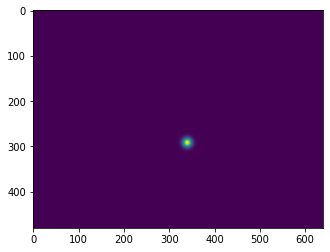

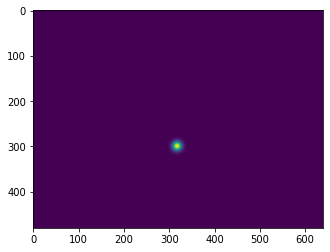

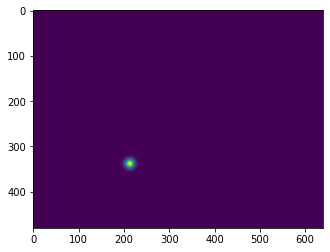

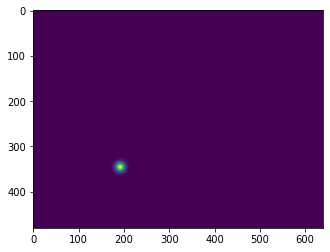

In [87]:
for i in heatmap.squeeze():
    plt.imshow(i)
    plt.show()

[[4.89542086e-04 8.36354739e-05 8.42396475e-05 ... 5.16430991e-05
  5.55473853e-05 2.31714058e-03]
 [2.09790633e-05 1.21846085e-06 1.74361344e-06 ... 1.05071251e-06
  1.01237492e-06 1.11710651e-04]
 [4.49969230e-05 2.44276748e-06 2.59601848e-06 ... 2.78865946e-06
  1.40261943e-06 8.26071919e-05]
 ...
 [1.99690985e-05 1.01103558e-06 8.90200795e-07 ... 1.17553702e-06
  6.84302847e-07 7.20626122e-05]
 [5.52227284e-05 2.53012695e-06 1.73618707e-06 ... 3.69899885e-06
  2.34253616e-06 1.13738854e-04]
 [9.38428391e-04 1.08275235e-04 6.22680891e-05 ... 1.58401162e-04
  1.14692062e-04 2.15143547e-03]]


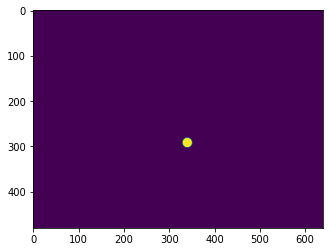

[[0.94144136 0.9708199  0.9836289  ... 0.9852035  0.9755474  0.9307404 ]
 [0.9832751  0.9926635  0.9976502  ... 0.997663   0.9967263  0.9925817 ]
 [0.97750914 0.995142   0.9982083  ... 0.9974226  0.9974854  0.9958973 ]
 ...
 [0.98050565 0.997056   0.9990822  ... 0.99785304 0.9977186  0.9958735 ]
 [0.9427053  0.98793346 0.99644107 ... 0.991289   0.9890954  0.98822   ]
 [0.8665122  0.9322629  0.97177535 ... 0.9559945  0.9429941  0.91016495]]


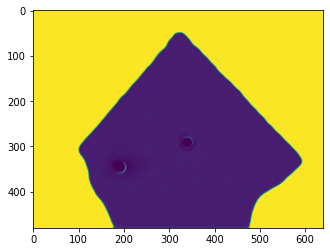

[[0.0569332  0.02904241 0.01621105 ... 0.01469476 0.02436154 0.06611811]
 [0.01659534 0.00733314 0.00234358 ... 0.00233211 0.00326974 0.00724597]
 [0.02218822 0.00484874 0.00177551 ... 0.00255813 0.00250405 0.00392783]
 ...
 [0.01937119 0.00294172 0.00091418 ... 0.00214294 0.00227868 0.00400824]
 [0.05680211 0.01206143 0.00355437 ... 0.00870169 0.0108974  0.01162111]
 [0.12694825 0.06731832 0.02798692 ... 0.04341159 0.05642925 0.08321529]]


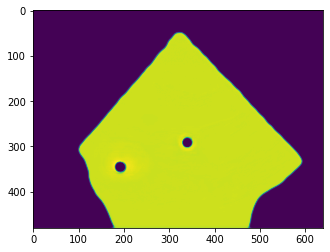

[[1.1358230e-03 5.4023953e-05 7.5854121e-05 ... 4.9977556e-05
  3.5490702e-05 8.2429661e-04]
 [1.0854631e-04 2.2903537e-06 4.4092121e-06 ... 3.7663649e-06
  2.7968622e-06 6.0639195e-05]
 [2.5759629e-04 6.7467363e-06 1.3619181e-05 ... 1.6524853e-05
  9.1097709e-06 9.2205271e-05]
 ...
 [1.0322735e-04 1.1932866e-06 2.7136041e-06 ... 2.8277605e-06
  1.9743561e-06 4.6210942e-05]
 [4.3745662e-04 2.6639852e-06 2.7338658e-06 ... 5.5664073e-06
  4.8331585e-06 4.5258588e-05]
 [5.6011113e-03 3.1056083e-04 1.7534979e-04 ... 4.3550538e-04
  4.6191158e-04 4.4683227e-03]]


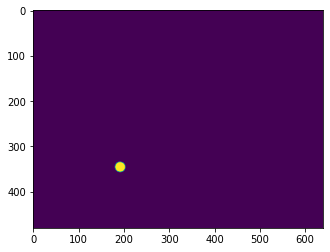

In [89]:
for i in result.squeeze():
    a = i.detach().clone().numpy()
    print(a)
    # a[a<=.3]=0
    
    plt.imshow(a)
    plt.show()

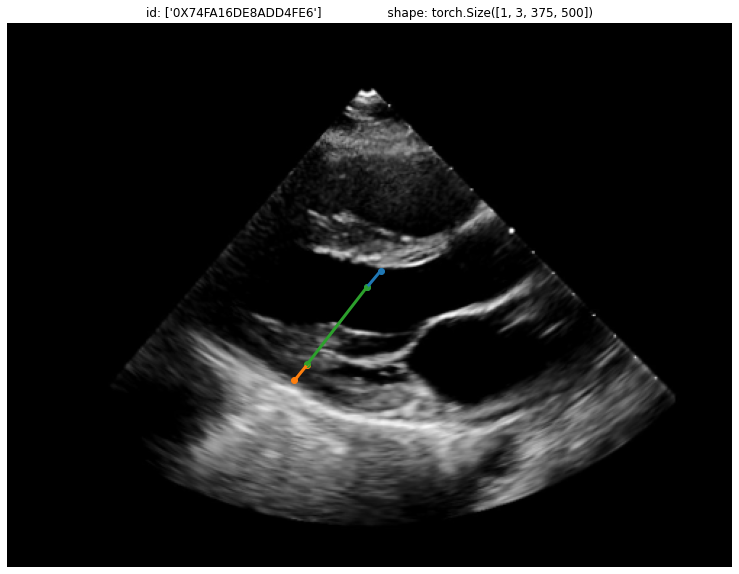

In [ ]:
show_lvh(s, )